# Multifunction radar design

This tutorial demonstrates how to simulate and design a multifunction radar system using PySTK. It is inspired by [this](https://help.agi.com/stk/Content/training/MFR_Tutorial.htm) tutorial.

## What are multifunction radar systems?

Multifunction radars have multiple beams which execute in parallel, allowing them to carry out multiple tasks simultaneously. Each of these beams can be configured individually and assigned independent tasks. A multifunction radar system can include beams that track a specific target, beams that scan the horizon, or beams that are fixed in one direction. A multifunction radar system can also control its system behavior dynamically, making changes that are based on pre-defined rules. For example, when a target is detected by one beam, the system can switch to another beam that is more suitable for that target. A multifunction radar system can also switch radar waveforms to increase fidelity. The switching control executes based on the range to a target that the radar is tracking. When the system detects a target, it can select a waveform that is appropriate to the target’s range classification.

## Problem statement

A radar site is located near a regional airport at latitude $34.7422^\circ$ and longitude $	-118.225^\circ$. The radar antenna is located $50$ ft above the ground. A small private aircraft with a radar cross section of $10$ dBsm flies through the zone from east to west.

A multifunction radar with three beams tracks the aircraft. The three beams are:

- A horizon search beam that is fixed and scans in one direction.
- A targeted beam that tracks the private plane once it is detected by the horizon search beam.
- A volume search beam that spins and scans the horizon.

Determine how well the radar system can track the plane.

## Launch a new STK instance

Start by launching a new STK instance. In this example, STKEngine is used.

In [1]:
from ansys.stk.core.stkengine import STKEngine


stk = STKEngine.start_application(no_graphics=False)

## Create a new scenario

Create a new scenario in STK by running:

In [2]:
root = stk.new_object_root()
root.new_scenario("MultifunctionRadar")

Once the scenario is created, it is possible to show a 3D graphics window by running:

RFBOutputContext()

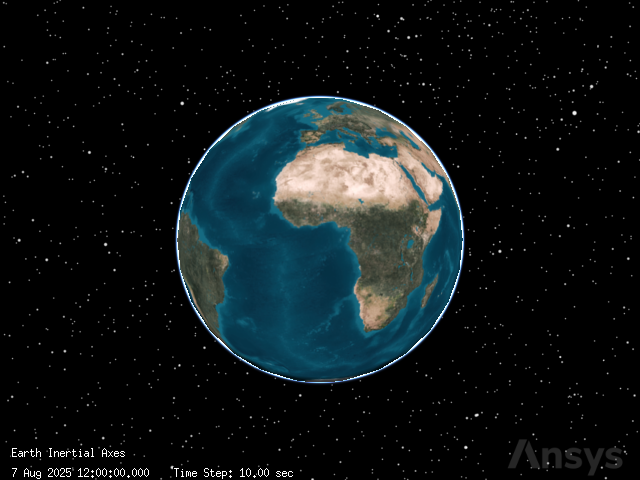

In [3]:
from ansys.stk.core.stkengine.experimental.jupyterwidgets import GlobeWidget


globe_plotter = GlobeWidget(root, 640, 480)
globe_plotter.show()

Show a 2D graphics window by running:

RFBOutputContext()

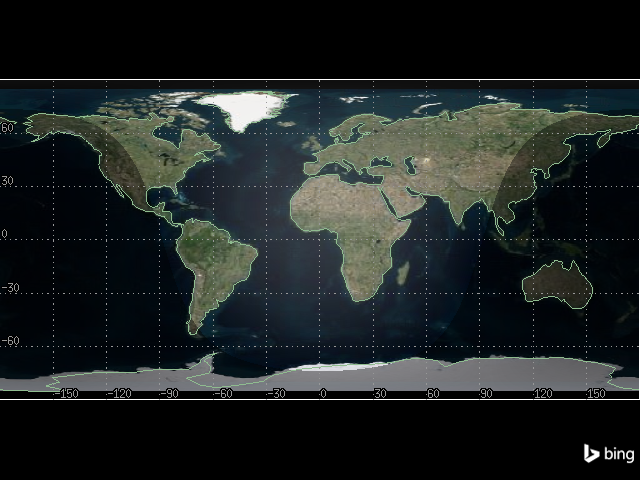

In [4]:
from ansys.stk.core.stkengine.experimental.jupyterwidgets import MapWidget


map_plotter = MapWidget(root, 640, 480)
map_plotter.show()

## Set the scenario time period

Using the newly created scenario, set the start and stop times. Rewind the scenario so that the graphics match the start and stop times of the scenario:

In [5]:
from ansys.stk.core.stkobjects import Scenario


scenario = Scenario(root.current_scenario)
scenario.set_time_period("26 Apr 2023 18:00:00.000", "26 Apr 2023 19:00:00.000")
root.rewind()

## Set the unit preferences

For this problem, the distances are be provided in feet, so change the distance unit preference to ft:

In [6]:
root.units_preferences.set_current_unit("distance", "ft")

## Create the radar site

The radar site is located near a regional airport, at latitude $34.7422^\circ$ and longitude $-118.225^\circ$ with a height $50$ ft above ground. First, insert a place object to represent the site:

In [7]:
from ansys.stk.core.stkobjects import Place, STKObjectType


radar_site = Place(scenario.children.new(STKObjectType.PLACE, "RadarSite"))

Then, assign the radar site's position:

In [8]:
radar_site.position.assign_geodetic(34.7422, -118.225, 0)

Finally, set the height above ground of the site to $50$ ft:

In [9]:
radar_site.height_above_ground = 50

## Create a small private aircraft

To model the small private aircraft flying from east to west through the airfield, insert an aircraft object:

In [10]:
from ansys.stk.core.stkobjects import Aircraft


small_aircraft = Aircraft(
    scenario.children.new(STKObjectType.AIRCRAFT, "SmallAircraft")
)

Then, configure the aircraft to use Mean Sea Level (MSL) as its altitude reference:

In [11]:
from ansys.stk.core.stkobjects import VehicleAltitudeReference


small_aircraft.route.set_altitude_reference_type(
    VehicleAltitudeReference.MEAN_SEA_LEVEL
)

The aircraft flies between two points. The first point is located at latitude $34.75^\circ$ and longitude $-117.50^\circ$. The second point is located at latitude $34.75^\circ$ and longitude $-119.0^\circ$. At both points, the aircraft flies at an altitude of $5000$ ft with a speed of $140$ mi/hr (equivalent to $205.333$ ft/sec).

Add the first waypoint to the aircraft's route:

In [12]:
waypoint1 = small_aircraft.route.waypoints.add()

Then, set the waypoint's latitude to $34.75^\circ$ and longitude to $-117.50^\circ$:

In [13]:
waypoint1.latitude = 34.75
waypoint1.longitude = -117.50

Set the waypoint's altitude to $5000$ ft:

In [14]:
waypoint1.altitude = 5000

Finally, set the speed of the plane at the waypoint to $205.333$ ft/sec:

In [15]:
waypoint1.speed = 205.333

Next, add the second waypoint to the aircraft's route:

In [16]:
waypoint2 = small_aircraft.route.waypoints.add()

Set the location of the waypoint to latitude $34.75^\circ$ and longitude $-119.0^\circ$, and set the altitude to $5000$ ft and speed to $205.333$ ft/sec:

In [17]:
waypoint2.latitude = 34.75
waypoint2.longitude = -119.0
waypoint2.altitude = 5000
waypoint2.speed = 205.333

Then, propagate the aircraft's route:

In [18]:
small_aircraft.route.propagate()

Next, specify the aircraft's RCS. Set the airliner's radar cross section's `inherit` property to false in order to override the default RCS value inherited from the scenario:

In [19]:
small_aircraft_rcs = small_aircraft.radar_cross_section
small_aircraft_rcs.inherit = False

Get the aircraft's RCS model, select the model's first frequency band, and configure the model to use a constant RCS of $10$ dBsm:

In [20]:
from ansys.stk.core.stkobjects import RadarCrossSectionModel


rcs_model = RadarCrossSectionModel(small_aircraft_rcs.model_component_linking.component)
band1 = rcs_model.frequency_bands[0]
band1.set_compute_strategy("Constant Value")
band1.compute_strategy.constant_value = 10

It is now possible to view the aircraft's route relative to the radar site using the 2D graphics window:

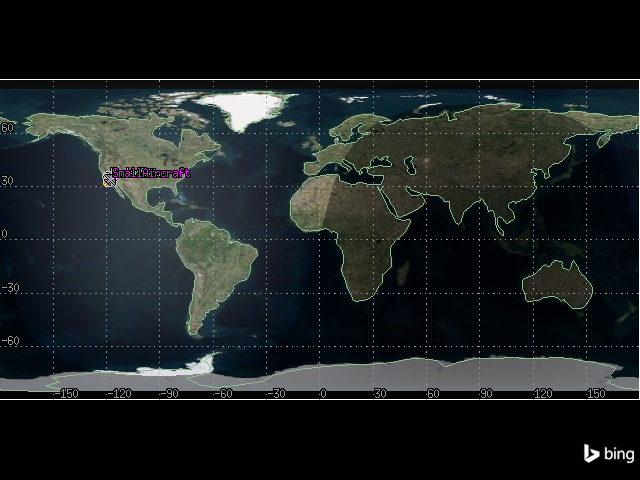

In [21]:
map_plotter.camera.position = [-30427439, 110996044, 0.0]
map_plotter.show()

## Create a multifunction radar system

To create the multifunction radar system, first insert a radar object on the radar site:

In [22]:
from ansys.stk.core.stkobjects import Radar


radar = Radar(radar_site.children.new(STKObjectType.RADAR, "MultifunctionRadar"))

Set the radar's model type to multifunction:

In [23]:
radar.model_component_linking.set_component("Multifunction")

Then, get the radar's model, which is now a `RadarModelMultifunction` object:

In [24]:
from ansys.stk.core.stkobjects import RadarModelMultifunction


multifunction_model = RadarModelMultifunction(radar.model_component_linking.component)

All the beams created in this scenario are oriented along the radar object's pointing type, which is fixed. Configure the radar model to use a fixed pointing strategy:

In [25]:
from ansys.stk.core.stkobjects import PointingStrategyType


multifunction_model.set_pointing_strategy_type(PointingStrategyType.FIXED)

Now, any beams created on the radar remain fixed relative to the radar itself.

Next, set the radar transmitter's power limit, which corresponds to the peak output power of the transmitter, to $40$ dBW:

In [26]:
multifunction_model.transmitter.maximum_power_limit = 40

Then, specify the transmitter polarization, which describes the orientation of the electric field vector with reference to the antenna's orientation. The transmitter is linearly polarized with the electrical field aligned with the reference axis.

First, enable the use of polarization on the transmitter:

In [27]:
multifunction_model.transmitter.enable_polarization = True

Set the transmitter's polarization type to linear:

In [28]:
from ansys.stk.core.stkobjects import PolarizationType


multifunction_model.transmitter.set_polarization_type(PolarizationType.LINEAR)

Next, specify the receiver polarization. Enable polarization on the receiver:

In [29]:
multifunction_model.receiver.enable_polarization = True

Then, set the receiver polarization to linear as well:

In [30]:
multifunction_model.receiver.set_polarization_type(PolarizationType.LINEAR)

Finally, add additional gain to the radar. In this scenario, it is necessary to model gains and losses that affect performance but are not defined using built-in analytical models. When the transmitted signal returns to the receiver, the system adds a separate gain to the signal.

Add a pre-receive gain of $10$ dB to the radar's receiver:

In [31]:
multifunction_model.receiver.pre_receive_gains_losses.add(10)

## Access the component directory

Some of the radar's beams use custom waveform strategies. Pre-configured waveform strategies are stored in the component browser, and can be duplicated to change and save them.

To create waveform strategies, first get all available radar components from the component directory:

In [32]:
from ansys.stk.core.stkobjects import Component


radar_components = scenario.component_directory.get_components(Component.RADAR)

Then, get the radar waveform components folder:

In [33]:
radar_waveform_components = radar_components.get_folder("Radar Waveforms")

## Create a horizon search beam and a targeted beam associated with it

The radar's first beam is a horizon search beam that is fixed in a single direction, with an azimuth of $85^\circ$ and an elevation of $3^\circ$. It has a beam width of $2^\circ$. Once the horizon search beam detects the private plane, the radar model switches to using an active tracking beam targeting the private plane. The beam has a beam width of $1.4^\circ$ and a gain of $30$ dB, and uses range-dependent waveform strategies.

First, select the first beam and name it "HorizonTargeted":

In [34]:
horizon_targeted = multifunction_model.antenna_beams.item(0)
horizon_targeted.identifier = "HorizonTargeted"

Then, create a new beam and name it "HorizonSearch":

In [35]:
horizon_search = multifunction_model.antenna_beams.add()
horizon_search.identifier = "HorizonSearch"

## Configure the horizon search beam

First, set the beam width to $2^\circ$:

In [36]:
horizon_search.beam_width = 2

The horizon search beam uses a rectangular waveform with a frequency of $3.5$ GHz. Get the rectangular waveform component from the component browser, then duplicate the component and name it "Horizon Search Rectangular":

In [37]:
horizon_search_rectangular_waveform = radar_waveform_components.duplicate_component(
    "Rectangular", "Horizon Search Rectangular"
)

Then, configure the waveform to have a frequency of $3.5$ GHz:

In [38]:
from ansys.stk.core.stkobjects import FrequencySpecificationType


horizon_search_rectangular_waveform.frequency_specification = (
    FrequencySpecificationType.FREQUENCY
)
horizon_search_rectangular_waveform.frequency = 3.5

Finally, configure the beam to use the waveform:

In [39]:
horizon_search.waveform_selection_strategy.fixed_waveform = "Horizon Search Rectangular"

Next, set the pointing properties for the beam. The beam points in a fixed direction, with an azimuth of $85^\circ$ and an elevation of $3^\circ$, and rotates about the boresight.

By default, the beam's pointing strategy is already set to fixed. Assign the azimuth and elevation for the beam, and configure it to rotate about the boresight:

In [40]:
from ansys.stk.core.stkutil import AzElAboutBoresight


horizon_search.pointing_strategy.orientation.assign_az_el(
    85, 3, AzElAboutBoresight.ROTATE
)

## Determine when the horizon search beam detects the private aircraft

First, get and compute the access between the radar and the small aircraft:

In [41]:
horizon_search_access = radar.get_access_to_object(small_aircraft)
horizon_search_access.compute_access()

Then, get the data for S/T Integrated SNR and S/T Integrated PDet over time, and view the first five rows of the data:

In [42]:
horizon_search_access_df = (
    horizon_search_access.data_providers.item("Radar Multifunction")
    .group.item("HorizonSearch")
    .execute_elements(
        scenario.start_time,
        "26 Apr 2023 18:36:35.057",
        1,
        ["S/T Integrated SNR", "S/T Integrated PDet", "Time"],
    )
    .data_sets.to_pandas_dataframe()
)
horizon_search_access_df.head(5)

,s/t integrated pdet,s/t integrated snr,time
0,0.0001001745655270937,-53.36434355350096,26 Apr 2023 18:00:00.000000000
1,0.00010017456378316388,-53.34796893393854,26 Apr 2023 18:00:01.000000000
2,0.00010017456203100844,-53.33157902177783,26 Apr 2023 18:00:02.000000000
3,0.00010017456027055924,-53.31517358750019,26 Apr 2023 18:00:03.000000000
4,0.00010017455850177996,-53.29875270215837,26 Apr 2023 18:00:04.000000000


Next, plot the S/T Integrated SNR and S/T Integrated PDet over time:

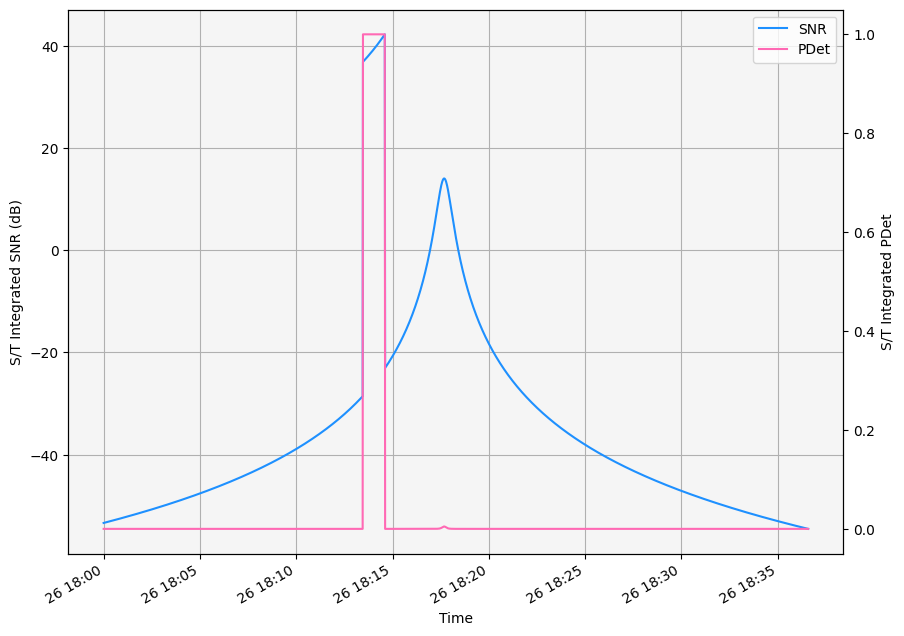

In [43]:
import matplotlib.dates as md
import matplotlib.pyplot as plt
import pandas as pd


# Convert columns to correct types
horizon_search_access_df_df_graphing = pd.DataFrame()
horizon_search_access_df_df_graphing["time"] = pd.to_datetime(
    horizon_search_access_df["time"]
)
horizon_search_access_df_df_graphing["s/t integrated snr"] = horizon_search_access_df[
    "s/t integrated snr"
].apply(pd.to_numeric)
horizon_search_access_df_df_graphing["s/t integrated pdet"] = horizon_search_access_df[
    "s/t integrated pdet"
].apply(pd.to_numeric)

# Create plot
fig, ax1 = plt.subplots(figsize=(10, 8))
ax2 = ax1.twinx()

# Plot data
horizon_search_access_df_df_graphing.plot.line(
    x="time", y="s/t integrated snr", color="dodgerblue", ax=ax1, label="SNR"
)
horizon_search_access_df_df_graphing.plot.line(
    x="time", y="s/t integrated pdet", color="hotpink", ax=ax2, label="PDet"
)

# Configure the style of the plot
ax1.set_facecolor("whitesmoke")
ax1.grid(visible=True, which="both")

# Combine legends
lines = ax1.get_lines() + ax2.get_lines()
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels)
ax2.get_legend().remove()

# Set axes labels
ax1.set_xlabel("Time")
ax1.set_ylabel("S/T Integrated SNR (dB)")
ax2.set_ylabel("S/T Integrated PDet")

plt.show()

When the private plane flies through the beam, S/T Integrated PDet and SNR (dB) spike. The S/T Integrated SNR (dB) rises as the range between the radar and the aircraft decreases. The S/T Integrated SNR increases in the middle of the graph because the range decreases and the private plane is in a side lobe.

Next, set the time interval for the Horizon Search beam. The beam begins searching at the scenario time, then stops once it detects the private plane. At that point, the radar switches to the targeted beam.

To set the interval, get the first time when the beam can track the plane with a PDet higher than 0.8:

In [44]:
horizon_search_access_df["s/t integrated pdet"] = horizon_search_access_df[
    "s/t integrated pdet"
].apply(pd.to_numeric)
first_time = horizon_search_access_df[
    horizon_search_access_df["s/t integrated pdet"] >= 0.8
].iloc[0]["time"]

Then set the beam's activity to use time intervals:

In [45]:
from ansys.stk.core.stkobjects import RadarActivityType


horizon_search.set_activity_type(RadarActivityType.TIME_INTERVAL_LIST)

Then, add an interval to the beam:

In [46]:
interval = horizon_search.activity.time_intervals.add()

Finally, set the stop time to the first time the plane is tracked:

In [47]:
interval.stop = first_time

## Configure the horizon targeted beam

Once the Horizon Search beam detects the private plane, the radar model switches to using an active tracking beam targeting the private plane. The beam has a beam width of $1.4^\circ$ and a gain of $30$ dB, and uses range-dependent waveform strategies.

First, set the beam width to $1.4^\circ$ and the gain to $30$ dB:

In [48]:
horizon_targeted.beam_width = 1.4
horizon_targeted.gain = 30

## Create range-dependent waveform strategies

It is possible to change a beam's frequency, power, or both by creating unique waveforms for that beam based on distance to the target. The horizon targeted beam tracks the private plane. During the scenario analysis period, the plane's distance from the radar site varies from $20$ to $250$ km. The beam switches waveforms based on the distance to the aircraft from the radar. The default waveform strategy settings in STK are optimal. However, for this scenario, the beam uses different frequencies based on the distance to the aircraft. Therefore, create and customize four new waveforms. STK's multifunction radar automatically switches from one waveform to another based on the distance between the plane and the radar site. Later, reuse these waveforms for a beam which targets the airliner.

The first waveform is used for long range. Duplicate the `Long Range Rectangular` component, and name the duplicate "Aircraft Long Range Rectangular":

In [49]:
long_range_rectangular_waveform = radar_waveform_components.duplicate_component(
    "Long Range Rectangular", "Aircraft Long Range Rectangular"
)

The long-range rectangular waveform uses low pulse repetition frequency (PRF) rectangular pulses, with a default PRF of $0.0005$ MHz. Configure the waveform's frequency to $2.0$ GHz:

In [50]:
from ansys.stk.core.stkobjects import FrequencySpecificationType


long_range_rectangular_waveform.frequency_specification = (
    FrequencySpecificationType.FREQUENCY
)
long_range_rectangular_waveform.frequency = 2.0

Next, set the medium-range rectangular waveform by duplicating the `Medium Range Rectangular` component, which uses a default PRF of $0.002$ MHz. Name the duplicate "Aircraft Medium Range Rectangular":

In [51]:
medium_range_rectangular_waveform = radar_waveform_components.duplicate_component(
    "Medium Range Rectangular", "Aircraft Medium Range Rectangular"
)

Configure the waveform's frequency to $3.0$ GHz:

In [52]:
medium_range_rectangular_waveform.frequency_specification = (
    FrequencySpecificationType.FREQUENCY
)
medium_range_rectangular_waveform.frequency = 3.0

Then, set the short-range rectangular waveform. Duplicate the `Short Range Rectangular` component, which uses a default PRF of $0.005$ MHz, and name the duplicate "Aircraft Short Range Rectangular":

In [53]:
short_range_rectangular_waveform = radar_waveform_components.duplicate_component(
    "Short Range Rectangular", "Aircraft Short Range Rectangular"
)

Set the waveform's frequency to $8.0$ GHz:

In [54]:
short_range_rectangular_waveform.frequency_specification = (
    FrequencySpecificationType.FREQUENCY
)
short_range_rectangular_waveform.frequency = 8.0

Finally, set the ultra-long-range rectangular waveform by duplicating the `Ultra Long Range Rectangular` component, which has a default PRF of $0.0001$ MHz, and naming the duplicate "Aircraft Ultra Long Range Rectangular":

In [55]:
ultra_long_range_rectangular_waveform = radar_waveform_components.duplicate_component(
    "Ultra Long Range Rectangular", "Aircraft Ultra Long Range Rectangular"
)

Set the waveform's frequency to $1.0$ GHz:

In [56]:
ultra_long_range_rectangular_waveform.frequency_specification = (
    FrequencySpecificationType.FREQUENCY
)
ultra_long_range_rectangular_waveform.frequency = 1.0

Next, override the beam's default waveform strategies in order to support dynamic waveform switching. Configure the beam's waveform strategy to use range limits to choose between waveforms:

In [57]:
from ansys.stk.core.stkobjects import WaveformSelectionStrategyType


horizon_targeted.set_waveform_selection_strategy(
    WaveformSelectionStrategyType.RANGE_LIMITS
)

Then, override the default selection strategies for all four ranges of waveforms:

In [58]:
horizon_targeted.waveform_selection_strategy.override_default_short_range_waveform = (
    True
)
horizon_targeted.waveform_selection_strategy.override_default_medium_range_waveform = (
    True
)
horizon_targeted.waveform_selection_strategy.override_default_long_range_waveform = True
horizon_targeted.waveform_selection_strategy.override_default_ultra_long_range_waveform = True

Finally, configure the beam to use the four previously configured waveform components:

In [59]:
horizon_targeted.waveform_selection_strategy.short_range_waveform = (
    "Aircraft Short Range Rectangular"
)
horizon_targeted.waveform_selection_strategy.medium_range_waveform = (
    "Aircraft Medium Range Rectangular"
)
horizon_targeted.waveform_selection_strategy.long_range_waveform = (
    "Aircraft Long Range Rectangular"
)
horizon_targeted.waveform_selection_strategy.ultra_long_range_waveform = (
    "Aircraft Ultra Long Range Rectangular"
)

Next, configure the pointing option for the Horizon Targeted beam. Set the pointing strategy type to targeted:

In [60]:
horizon_targeted.set_pointing_strategy_type(PointingStrategyType.TARGETED)

It is possible to see all of the available targets for the beam by running:

In [61]:
horizon_targeted.pointing_strategy.available_target_objects

['Aircraft/SmallAircraft']

Assign the private plane as the target:

In [62]:
horizon_targeted.pointing_strategy.target_object = "Aircraft/SmallAircraft"

## View how waveform strategies vary with range for the horizon targeted beam

First, get and compute the access between the radar and the aircraft:

In [63]:
horizon_targeted_airplane_access = radar.get_access_to_object(small_aircraft)
horizon_targeted_airplane_access.compute_access()

Then, get the data for S/T PDet1, S/T Integrated PDet, and Waveform ID over time, and view the first five rows of the data:

In [64]:
horizon_targeted_access_df = (
    horizon_targeted_airplane_access.data_providers.item("Radar Multifunction")
    .group.item("HorizonTargeted")
    .execute_elements(
        scenario.start_time,
        scenario.stop_time,
        10,
        ["S/T PDet1", "S/T Integrated PDet", "Time", "Waveform ID"],
    )
    .data_sets.to_pandas_dataframe()
)
horizon_targeted_access_df.head(5)

,s/t integrated pdet,s/t pdet1,time,waveform id
0,0.999633090008432,0.1485120952256964,26 Apr 2023 18:00:00.000000000,Aircraft_Long_Range_Rectangular
1,0.9992090696427715,0.1622263651262525,26 Apr 2023 18:00:10.000000000,Aircraft_Long_Range_Rectangular
2,0.9995544923471046,0.17778627114177797,26 Apr 2023 18:00:20.000000000,Aircraft_Long_Range_Rectangular
3,0.9997598505392916,0.19417124541870723,26 Apr 2023 18:00:30.000000000,Aircraft_Long_Range_Rectangular
4,0.9998765226200849,0.21191980819163767,26 Apr 2023 18:00:40.000000000,Aircraft_Long_Range_Rectangular


Then, get the data for the range between the aircraft and the radar over the duration of the scenario:

In [65]:
horizon_targeted_aer_df = (
    horizon_targeted_airplane_access.data_providers.item("AER Data")
    .group.item("Default")
    .execute_elements(
        scenario.start_time,
        scenario.stop_time,
        10,
        ["Time", "Range"],
    )
    .data_sets.to_pandas_dataframe()
)
horizon_targeted_aer_df.head(5)

,time,range
0,26 Apr 2023 18:00:00.000000000,217877.61131736395
1,26 Apr 2023 18:00:10.000000000,215824.8819606678
2,26 Apr 2023 18:00:20.000000000,213772.1618459629
3,26 Apr 2023 18:00:30.000000000,211719.44996986052
4,26 Apr 2023 18:00:40.000000000,209666.7465950436


Then, combine the data for range and the data for S/T Integrated PDet and S/t PDet 1 over time and view the first five rows of the data:

In [66]:
df_merged = pd.merge(
    horizon_targeted_aer_df, horizon_targeted_access_df, on="time", how="inner"
)
df_merged.head(5)

,time,range,s/t integrated pdet,s/t pdet1,waveform id
0,26 Apr 2023 18:00:00.000000000,217877.61131736395,0.999633090008432,0.1485120952256964,Aircraft_Long_Range_Rectangular
1,26 Apr 2023 18:00:10.000000000,215824.8819606678,0.9992090696427715,0.1622263651262525,Aircraft_Long_Range_Rectangular
2,26 Apr 2023 18:00:20.000000000,213772.1618459629,0.9995544923471046,0.17778627114177797,Aircraft_Long_Range_Rectangular
3,26 Apr 2023 18:00:30.000000000,211719.44996986052,0.9997598505392916,0.19417124541870723,Aircraft_Long_Range_Rectangular
4,26 Apr 2023 18:00:40.000000000,209666.7465950436,0.9998765226200849,0.21191980819163767,Aircraft_Long_Range_Rectangular


Next, find the time at which the range is the lowest, and multiply the range values up to that point by -1:

In [67]:
df_merged["s/t integrated pdet"] = df_merged["s/t integrated pdet"].apply(pd.to_numeric)
df_merged["range"] = df_merged["range"].apply(pd.to_numeric)
df_merged.loc[: df_merged["range"].idxmin() - 1, "range"] = (
    df_merged.loc[: df_merged["range"].idxmin() - 1, "range"] * -1
)
df_merged.head(5)

,time,range,s/t integrated pdet,s/t pdet1,waveform id
0,26 Apr 2023 18:00:00.000000000,-217877.611317,0.999633,0.1485120952256964,Aircraft_Long_Range_Rectangular
1,26 Apr 2023 18:00:10.000000000,-215824.881961,0.999209,0.1622263651262525,Aircraft_Long_Range_Rectangular
2,26 Apr 2023 18:00:20.000000000,-213772.161846,0.999554,0.17778627114177797,Aircraft_Long_Range_Rectangular
3,26 Apr 2023 18:00:30.000000000,-211719.449970,0.999760,0.19417124541870723,Aircraft_Long_Range_Rectangular
4,26 Apr 2023 18:00:40.000000000,-209666.746595,0.999877,0.21191980819163767,Aircraft_Long_Range_Rectangular


Finally, plot the range vs. S/T Integrated PDet for each waveform type:

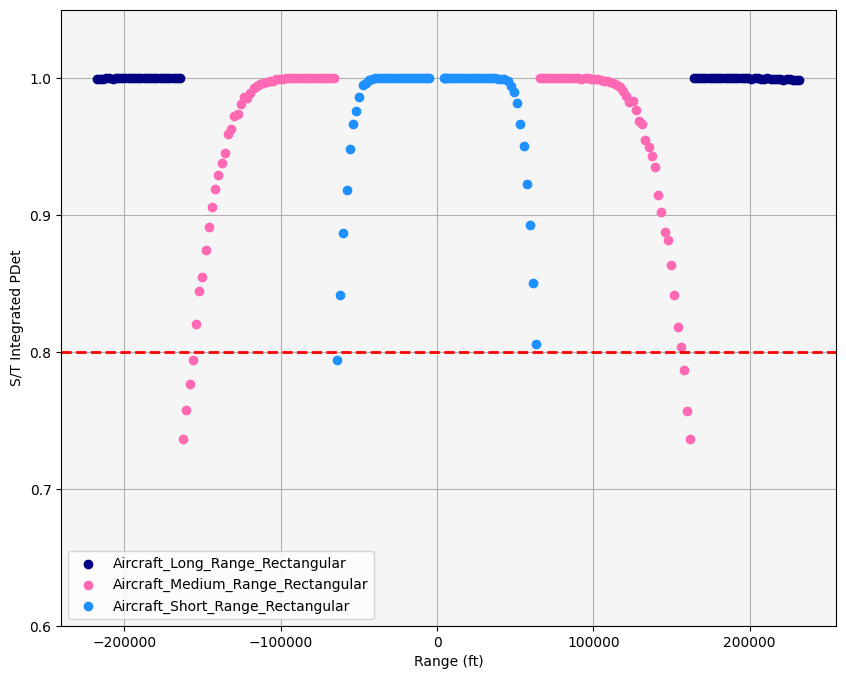

In [68]:
# Create plot
fig, ax = plt.subplots(figsize=(10, 8))

# Plot data by waveform
colors = ["navy", "hotpink", "dodgerblue", "pink"]
i = 0
for label in df_merged["waveform id"].unique():
    x = df_merged[df_merged["waveform id"] == label]["range"]
    y = df_merged[df_merged["waveform id"] == label]["s/t integrated pdet"]

    ax.scatter(x, y, color=colors[i], label=label)
    i += 1

# Configure styling
ax.set_facecolor("whitesmoke")
ax.grid(visible=True, which="both")
ax.set_axisbelow(True)
ax.legend()

# Configure axes
ax.set_ylim(bottom=0.6)
ax.set_xlabel("Range (ft)")
ax.set_ylabel("S/T Integrated PDet")

# Add line representing 0.8 PDet
ax.axhline(y=0.8, color="red", linestyle="--", linewidth=2)

plt.show()

A negative range indicates that the private plane is approaching the radar site, while a positive range means that the plane is moving away from the site. The range is 0 when the plane is directly above the site.

The ultra long range waveform is never used, as the aircraft is never far enough from the radar site for the beam to switch to this waveform. Because the beam moves between waveforms based on range from the target, there is good tracking (above 0.8 PDet) at almost all times. The only times when the PDet is below 0.8 is when the respective waveforms are used at the very limits of their configured ranges.

## Configure the target airliner beam's start time

Next, configure the beam to start tracking the private plane when the horizon search beam is first able to track it. Configure the beam to use a time interval list as its activity type:

In [69]:
from ansys.stk.core.stkobjects import RadarActivityType


horizon_targeted.set_activity_type(RadarActivityType.TIME_INTERVAL_LIST)

Then, add an interval to the beam's activity, and set the start time to the first time the horizon search beam detects the aircraft:

In [70]:
interval = horizon_targeted.activity.time_intervals.add()
interval.start = first_time

## Determine when the horizon targeted beam detects the private aircraft

Recompute the access between the radar and the small aircraft:

In [71]:
horizon_targeted_airplane_access.compute_access()

Then, get the data for S/T PDet1 and S/T Integrated PDet over time, and view the first five rows of the data:

In [72]:
horizon_targeted_access_df = (
    horizon_targeted_airplane_access.data_providers.item("Radar Multifunction")
    .group.item("HorizonTargeted")
    .execute_elements(
        scenario.start_time,
        scenario.stop_time,
        1,
        ["S/T PDet1", "S/T Integrated PDet", "Time"],
    )
    .data_sets.to_pandas_dataframe()
)
horizon_targeted_access_df.head(5)

,s/t integrated pdet,s/t pdet1,time
0,0.9760980261415276,0.013724321716949556,26 Apr 2023 18:13:28.000000000
1,0.9793747062578052,0.01422083450338697,26 Apr 2023 18:13:29.000000000
2,0.9761283327917564,0.014737747182353794,26 Apr 2023 18:13:30.000000000
3,0.9794124743390872,0.015275897539162609,26 Apr 2023 18:13:31.000000000
4,0.9823326130615648,0.01583613251335886,26 Apr 2023 18:13:32.000000000


Next, plot the S/T PDet1 and S/T Integrated PDet over time:

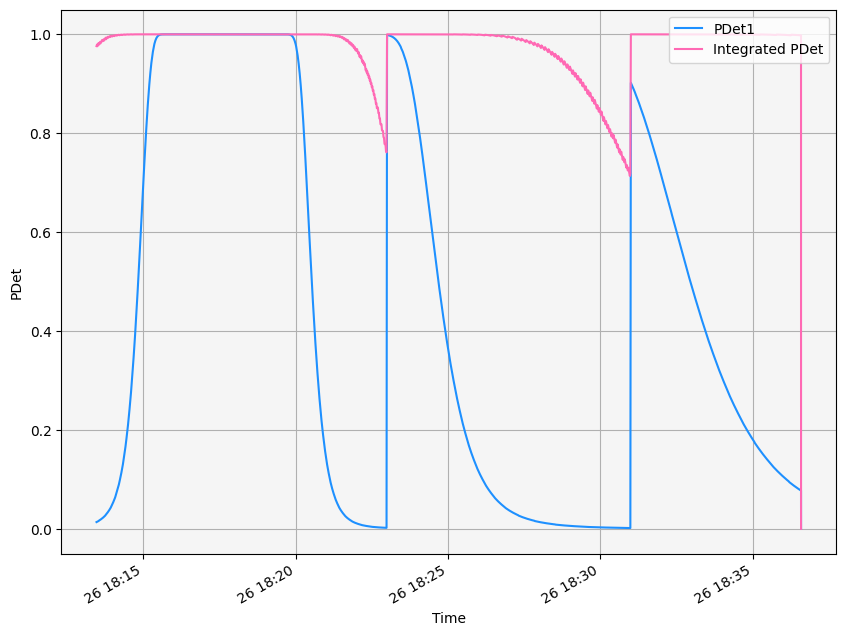

In [73]:
# Convert columns to correct types
horizon_targeted_access_df_graphing = pd.DataFrame()
horizon_targeted_access_df_graphing["time"] = pd.to_datetime(
    horizon_targeted_access_df["time"]
)
horizon_targeted_access_df_graphing["s/t pdet1"] = horizon_targeted_access_df[
    "s/t pdet1"
].apply(pd.to_numeric)
horizon_targeted_access_df_graphing["s/t integrated pdet"] = horizon_targeted_access_df[
    "s/t integrated pdet"
].apply(pd.to_numeric)

# Create plot
fig, ax = plt.subplots(figsize=(10, 8))

# Plot data
horizon_targeted_access_df_graphing.plot.line(
    x="time", y="s/t pdet1", color="dodgerblue", ax=ax, label="PDet1"
)
horizon_targeted_access_df_graphing.plot.line(
    x="time", y="s/t integrated pdet", color="hotpink", ax=ax, label="Integrated PDet"
)

# Configure the style of the plot
ax.set_facecolor("whitesmoke")
ax.grid(visible=True, which="both")

# Set axes labels
ax.set_xlabel("Time")
ax.set_ylabel("PDet")

# Configure legend
plt.legend(loc="upper right")

plt.show()

S/T PDet1 uses one pulse and S/T Integrated PDet uses up to 512 pulses. Both S/T PDet1 and S/T Integrated PDet show reflections from the private plane. However, the S/T PDet1 values drop twice, while the S/T Integrated PDet values only drop below 0.8 on two instances.

Once the horizon targeted beam can no longer track the private plane, the radar switches back to using the horizon search beam. To configure the time intervals, first find the first time that the horizon targeted beam cannot see the private plane with a PDet above 0.8:

In [74]:
horizon_targeted_access_df["s/t integrated pdet"] = horizon_targeted_access_df[
    "s/t integrated pdet"
].apply(pd.to_numeric)
last_time = horizon_targeted_access_df[
    horizon_targeted_access_df["s/t integrated pdet"] < 0.8
].iloc[0]["time"]

Then, add a new time interval to the horizon search beam's activity:

In [75]:
interval2 = horizon_search.activity.time_intervals.add()

Set the start time to the last time that the horizon targeted beam can track the aircraft:

In [76]:
interval2.start = last_time

Then, configure the horizon targeted beam to turn off once it can no longer track the private plane:

In [77]:
interval.stop = last_time

## Create a volume search beam

The last beam on the radar is a volume search beam that scans the horizon. The beam has a gain of $30$ dB and a beam width of $5^\circ$. It spins continuously over $360^\circ$. The cone angle is $87^\circ$ with a spin rate of $60^\circ$ per second.

First, create the beam by adding a beam to the multifunction model's antenna beams:

In [78]:
volume_search = multifunction_model.antenna_beams.add()

Then, rename the beam to "VolumeSearch":

In [79]:
volume_search.identifier = "VolumeSearch"

To set the beam width, it is necessary to first set the beam's gain, because a larger beam width necessitates a lower gain. If the beam width were set first, STK would produce an invalid sidelobe gain computation error.

First set the gain to $30$ dB and then the beam width to $5^\circ$:

In [80]:
volume_search.gain = 30
volume_search.beam_width = 5

Next, configure the volume search beam's waveform strategy. The beam uses a volume search rectangular waveform, with a frequency of $3.5$ GHz and a power of $50$ dBW.

First, get the `Rectangular` waveform component, then duplicate it and name the duplicate "Volume Search Rectangular":

In [81]:
volume_search_rectangular_waveform = radar_waveform_components.duplicate_component(
    "Rectangular", "Volume Search Rectangular"
)

Next, configure the waveform to use frequency, then set the frequency to $3.5$ GHz and the power to $50$ dBW:

In [82]:
volume_search_rectangular_waveform.frequency_specification = (
    FrequencySpecificationType.FREQUENCY
)
volume_search_rectangular_waveform.frequency = 3.5
volume_search_rectangular_waveform.power = 50

Then, configure the volume search beam to use the waveform:

In [83]:
volume_search.waveform_selection_strategy.fixed_waveform = "Volume Search Rectangular"

Next, set the beam's pointing type to spinning:

In [84]:
volume_search.set_pointing_strategy_type(PointingStrategyType.SPINNING)

The beam's `pointing_strategy` property now returns a `PointingStrategySpinning` object. Use the `PointingStrategySpinning` object to set the cone angle to $87^\circ$ and the spin rate to $60^\circ$ per second:

In [85]:
point_strategy = volume_search.pointing_strategy
point_strategy.cone_angle = 87
point_strategy.spin_rate = 60

## Determine when the beam can track the plane

To determine when the beam can track the aircraft, first get and compute the access between the radar and the small aircraft:

In [86]:
volume_search_access = radar.get_access_to_object(small_aircraft)
volume_search_access.compute_access()

Then, get the data for Time, S/T Integrated SNR, S/T Integrated PDet, and S/T Pulses Integrated every minute during both accesses:

In [87]:
elements = [
    "Time",
    "S/T Integrated SNR",
    "S/T Integrated PDet",
    "S/T Pulses Integrated",
]
volume_search_access_df = (
    volume_search_access.data_providers.item("Radar Multifunction")
    .group.item("VolumeSearch")
    .execute_elements(scenario.start_time, scenario.stop_time, 60, elements)
    .data_sets.to_pandas_dataframe()
)

Finally, plot the S/T Integrated SNR and S/T Integrated PDet over the duration of the scenario:

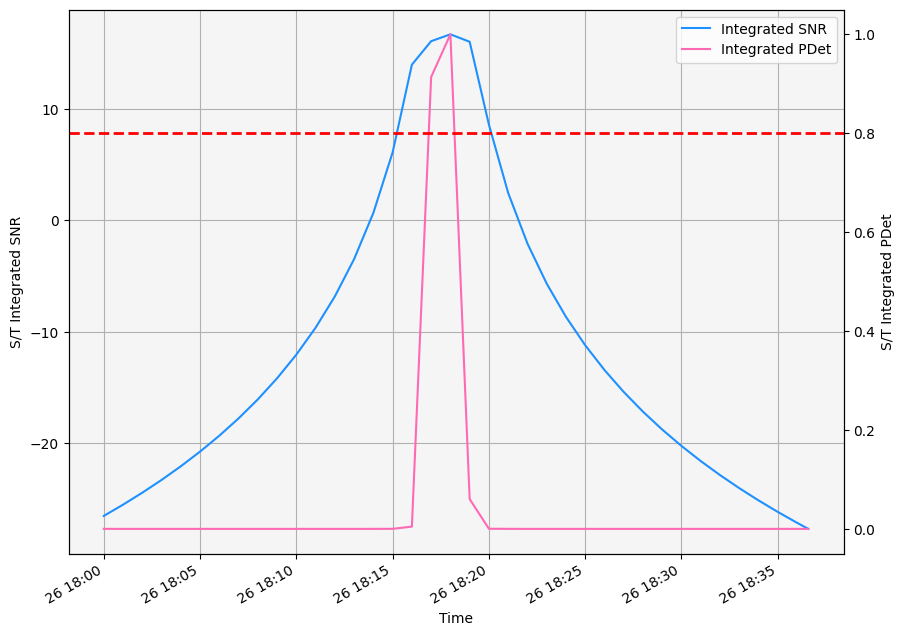

In [88]:
# Convert columns to correct types
volume_search_access_df["time"] = pd.to_datetime(volume_search_access_df["time"])
volume_search_access_df["s/t integrated snr"] = volume_search_access_df[
    "s/t integrated snr"
].apply(pd.to_numeric)
volume_search_access_df["s/t integrated pdet"] = volume_search_access_df[
    "s/t integrated pdet"
].apply(pd.to_numeric)

# Create plot
fig, ax1 = plt.subplots(figsize=(10, 8))
ax2 = ax1.twinx()

# Plot data
volume_search_access_df.plot.line(
    x="time", y="s/t integrated snr", color="dodgerblue", ax=ax1, label="Integrated SNR"
)
volume_search_access_df.plot.line(
    x="time", y="s/t integrated pdet", color="hotpink", ax=ax2, label="Integrated PDet"
)

# Configure the style of the plot
ax1.set_facecolor("whitesmoke")
ax1.grid(visible=True, which="both")

# Combine legends
lines = ax1.get_lines() + ax2.get_lines()
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc="upper right")
ax2.get_legend().remove()

# Add line representing 0.8 PDet
ax2.axhline(y=0.8, color="red", linestyle="--", linewidth=2)

# Set title and axes labels
ax1.set_xlabel("Time")
ax1.set_ylabel("S/T Integrated SNR")
ax2.set_ylabel("S/T Integrated PDet")

plt.show()

The volume search beam obtains reflections from the private plane. There are a couple of instances in which the S/T Integrated PDet for the private plane is above 0.80000, so the volume search picks up the private plane.

## Visualize the radar system

First, configure the 3D graphics for the radar. Changes to the radar's 3D graphics settings are applied to all beams in the system.

Configure graphics to show the volumes of the beams:

In [89]:
radar.graphics_3d.volume.show = True

Then, set the gain scale to $328$ ft/dB:

In [90]:
radar.graphics_3d.volume.gain_scale = 328

Then, for both azimuth and elevation, set the volume graphics resolution to $0.5^\circ$ ranging from $-180^\circ$ to $180^\circ$:

In [91]:
radar.graphics_3d.volume.set_resolution(-180, 180, 0.5, -180, 180, 0.5)

It is now possible to see the beams in the 3D graphics window:

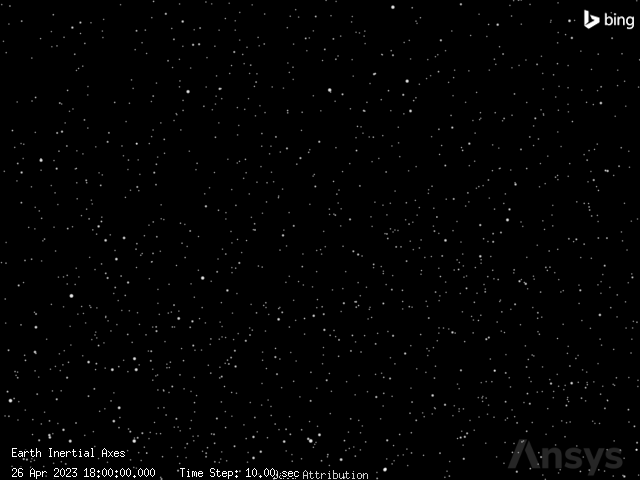

In [92]:
globe_plotter.camera.position = [17039826, 2810211, 11818867]
globe_plotter.show()

Only the volume search and horizon search beams are visible at this point, as the horizon targeted beam is inactive at the start of the scenario and so does not have graphics associated with it.

To view the horizon targeted beam, convert the first time that the target airliner is active to epoch seconds, then set the animation current time:

In [93]:
root.current_time = float(
    root.conversion_utility.convert_date("UTCG", "EpSec", first_time)
)

Then, view the horizon targeted beam and volume search beams:

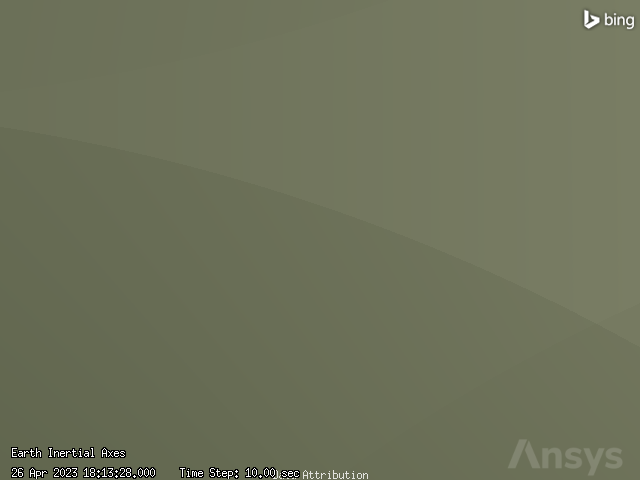

In [94]:
globe_plotter.camera.position = [17039826, 2810211, 11818867]
globe_plotter.show()

The horizon search beam is no longer active, so it is not shown.